In [1]:
import os
import glob
import ntpath
import textwrap
import numpy as np
import pandas as pd
import nibabel as nib
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
import util

# load myelin & thickness

In [3]:
# load csv file that contains all the measures
path_data = '<Path>'

fn_myl = '{}/Greyordinate_SmoothedMyelinMap_Run202105_N485.csv'.format(path_data)
fn_thk = '{}/Greyordinate_corrThickness_Run202105_N485.csv'.format(path_data)

myl_df = pd.read_csv(fn_myl, index_col = 0, low_memory = False).astype('float32')
thk_df = pd.read_csv(fn_thk, index_col = 0, low_memory = False).astype('float32')

print('myl_df.shape: ', myl_df.shape)
print('thk_df.shape: ', thk_df.shape)

myl_df.shape:  (485, 59412)
thk_df.shape:  (485, 59412)


In [4]:
# take the log (important!)
myl_df[myl_df<=0] = 0.01 # replace 28 values that is <= 0
myl_df = np.log(myl_df)

In [5]:
fn_subj = '{}/subject_list_n443.txt'.format(path_data)
subj_df = pd.read_csv(fn_subj, index_col = 0, header=None)

subj_list = subj_df.index
n_subj = len(subj_list)

fn_demo = '{}/All-Measures-demographics.csv'.foramt(path_data)
demo_df = pd.read_csv(fn_demo, index_col = 0)

myl_df = myl_df.loc[subj_list,:]
thk_df = thk_df.loc[subj_list,:]
age_df = demo_df.loc[subj_list,['Age']]

print('myl_df.shape: ', myl_df.shape)
print('thk_df.shape: ', thk_df.shape)
print('age_df.shape: ', age_df.shape)

myl_df.shape:  (443, 59412)
thk_df.shape:  (443, 59412)
age_df.shape:  (443, 1)


## load FC matrices

In [6]:
fn_fc = '{}/fc_matrices/sum_n443.dat'.format(path_data)
add = np.memmap(fn_fc, dtype='float32', mode='r', shape=(1764863166,))
add = add/n_subj # Change denominator based on subgroups
X = np.zeros((59412,59412))
X[np.triu_indices(X.shape[0], k = 1)] = add
del add

fc_mat_df = pd.DataFrame(X + X.T + np.eye(X.shape[0]),
                         index=myl_df.columns,
                         columns=myl_df.columns).astype('float32')

del X

# helper function

In [6]:
def demean(df):
    mean_df = df.mean(axis = 1)
    demean_df = df.sub(mean_df, axis = 'index')
    return demean_df

# regress out age effect
def age_residual_voxel(to_reg_df, age_df):
    age_const_df = age_df.copy()
    age_const_df.loc[:,'const'] = np.ones((age_df.shape[0], 1))
    Y = to_reg_df.values
    X = age_const_df.values
    coef, res, rank, s = np.linalg.lstsq(X, Y, rcond = None)
    print('coef.shape:', coef.shape)

    reg_mat = to_reg_df.values - np.matmul(age_const_df.values, coef) # remove age and const terms
    reg_df = pd.DataFrame(reg_mat, 
                          index = to_reg_df.index, 
                          columns = to_reg_df.columns)

    coef_df = pd.DataFrame(coef.T, 
                           columns = age_const_df.columns,
                           index = to_reg_df.columns)
    return reg_df, coef_df

def corr(df1, df2):
    n = len(df1)
    v1, v2 = df1.values, df2.values
    sums = np.multiply.outer(v2.sum(0), v1.sum(0))
    stds = np.multiply.outer(v2.std(0), v1.std(0))
    return pd.DataFrame((v2.T.dot(v1) - sums / n) / stds / n, df2.columns, df1.columns)

def corr_chunck(df0):
    ncol = df0.shape[1] # 59412
    ncolchk = np.int(ncol/4) # 14853

    # create matrix to store corr
    corr_mat = np.zeros((ncol, ncol), dtype = np.float32)

    for ichunk1 in np.arange(4):
        for ichunk2 in np.arange(ichunk1,4):
            print('...chunck 4-by-4:', ichunk1+1, ichunk2+1)
            colidx1 = ichunk1 * ncolchk + np.arange(ncolchk)
            colidx2 = ichunk2 * ncolchk + np.arange(ncolchk)
            df1 = df0.iloc[:,colidx1]
            df2 = df0.iloc[:,colidx2]

            corr_df21 = corr(df1, df2) 
            corr_df12 = np.transpose(corr_df21) # df1.col * df2.col

            corr_mat[colidx1.reshape(-1,1), colidx2] = corr_df12.values
            corr_mat[colidx2.reshape(-1,1), colidx1] = corr_df21.values
            
    return corr_mat

def metacorr_chuck(df1, df2):
    ncol = df1.shape[1] # 59412
    nchk = 40
    ncolpchk = np.floor(ncol/nchk)+1 # 1485.3
    metacorr = pd.Series(np.zeros(ncol))
    
    for ii in np.arange(nchk):
        print('...chunck:{}/40'.format(ii+1))
        idx = np.arange(ii*ncolpchk, min((ii+1)*ncolpchk, ncol)).astype(int)
        corr_chk_df1 = corr(df1.iloc[:,idx], df1)  # df1.col * chk_df1.col
        corr_chk_df2 = corr(df2.iloc[:,idx], df2)  # df2.col * chk_df2.col
        metacorr[idx] = corr_chk_df1.corrwith(corr_chk_df2, axis = 0).values    
    
    return metacorr

def metacorr_chuck_2(df1, corrmat_df2):
    ncol = df1.shape[1] # 59412
    nchk = 40
    ncolpchk = np.floor(ncol/nchk)+1 # 1485.3
    metacorr = pd.Series(np.zeros(ncol))
    
    for ii in np.arange(nchk):
        print('...chunck:{}/40'.format(ii+1))
        idx = np.arange(ii*ncolpchk, min((ii+1)*ncolpchk, ncol)).astype(int)
        corr_chk_df1 = corr(df1.iloc[:,idx], df1)  # df1.col * chk_df1.col
        corr_chk_df2 = corrmat_df2.iloc[:,idx]     # df2.col * chk_df2.col
        metacorr[idx] = corr_chk_df1.corrwith(corr_chk_df2, axis = 0).values    
    
    return metacorr

def upper_tri_masking(A):
    # get the upper triangle of matrix without diagonal
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

# mean (orig) & age-coef (orig)

In [7]:
# demeaned
dm_thk_df = demean(thk_df)
dm_myl_df = demean(myl_df)

mean_dm_thk_df = dm_thk_df.mean(axis = 0)
mean_dm_myl_df = dm_myl_df.mean(axis = 0)

_, age_coef_thk = age_residual_voxel(demean(thk_df), age_df)
_, age_coef_myl = age_residual_voxel(demean(myl_df), age_df)

age_coef_thk = age_coef_thk['Age']
age_coef_myl = age_coef_myl['Age']

coef.shape: (2, 59412)
coef.shape: (2, 59412)


In [9]:
# original not demeaned
mean_thk_df = thk_df.mean(axis = 0)
mean_myl_df = myl_df.mean(axis = 0)

_, age_coef_thk = age_residual_voxel(thk_df, age_df)
_, age_coef_myl = age_residual_voxel(myl_df, age_df)

age_coef_thk = age_coef_thk['Age']
age_coef_myl = age_coef_myl['Age']

coef.shape: (2, 59412)
coef.shape: (2, 59412)


In [10]:
mean_thk_df.to_csv('mean_orig_thk_n{}.csv'.format(n_subj))
mean_myl_df.to_csv('mean_orig_myl_n{}.csv'.format(n_subj))
age_coef_thk.to_csv('age_coef_orig_thk_n{}.csv'.format(n_subj))
age_coef_myl.to_csv('age_coef_orig_myl_n{}.csv'.format(n_subj))

util.wbview_saveas_dscalar('mean_orig_thk_n{}.csv'.format(n_subj))
util.wbview_saveas_dscalar('mean_orig_myl_n{}.csv'.format(n_subj))
util.wbview_saveas_dscalar('age_coef_orig_thk_n{}.csv'.format(n_subj))
util.wbview_saveas_dscalar('age_coef_orig_myl_n{}.csv'.format(n_subj))

# myl/thk covariance matrix (all subjects)

In [10]:
def show_matrix(mtx, vrange, cmap):
    vmin, vmax = vrange
#     plt.figure(figsize = (8, 8))
    plt.figure()
    im = plt.imshow(mtx, cmap = cmap, vmin = vmin, vmax =vmax)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

...chunck 4-by-4: 1 1
...chunck 4-by-4: 1 2
...chunck 4-by-4: 1 3
...chunck 4-by-4: 1 4
...chunck 4-by-4: 2 2
...chunck 4-by-4: 2 3
...chunck 4-by-4: 2 4
...chunck 4-by-4: 3 3
...chunck 4-by-4: 3 4
...chunck 4-by-4: 4 4


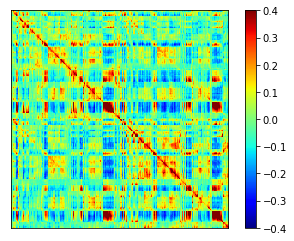

In [12]:
# on nzxt
cormat_myl = corr_chunck(dm_myl_df)

show_matrix(cormat_myl, (-0.4, 0.4), 'jet')
plt.savefig('matrix_myelin_n{}.pdf'.format(n_subj), bbox_inches = 'tight')
del cormat_myl

...chunck 4-by-4: 1 1
...chunck 4-by-4: 1 2
...chunck 4-by-4: 1 3
...chunck 4-by-4: 1 4
...chunck 4-by-4: 2 2
...chunck 4-by-4: 2 3
...chunck 4-by-4: 2 4
...chunck 4-by-4: 3 3
...chunck 4-by-4: 3 4
...chunck 4-by-4: 4 4


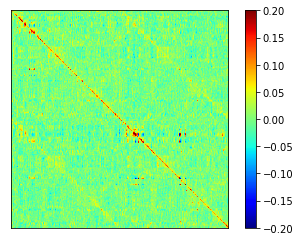

In [13]:
# on nzxt
cormat_thk = corr_chunck(dm_thk_df)

show_matrix(cormat_thk, (-0.2, 0.2), 'jet')
plt.savefig('matrix_thickness_n{}.pdf'.format(n_subj), bbox_inches = 'tight')
del cormat_thk

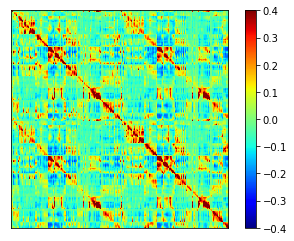

In [11]:
# on nzxt
show_matrix(fc_mat_df.values, (-0.4, 0.4), 'jet')
plt.savefig('matrix_fc_n{}.pdf'.format(n_subj), bbox_inches = 'tight')

# meta-corr (all subjects)

In [12]:
dm_thk_df = demean(thk_df)
dm_myl_df = demean(myl_df)

metacorr_mf = metacorr_chuck_2(dm_myl_df, fc_mat_df)
metacorr_tf = metacorr_chuck_2(dm_thk_df, fc_mat_df)
metacorr_mt = metacorr_chuck(dm_myl_df, dm_thk_df)

metacorr_mf.to_csv('metacorr_dmMdmF_n{}.csv'.format(n_subj))
metacorr_tf.to_csv('metacorr_dmTdmF_n{}.csv'.format(n_subj))
metacorr_mt.to_csv('metacorr_dmMdmT_n{}.csv'.format(n_subj))

...chunck:1/40
...chunck:2/40
...chunck:3/40
...chunck:4/40
...chunck:5/40
...chunck:6/40
...chunck:7/40
...chunck:8/40
...chunck:9/40
...chunck:10/40
...chunck:11/40
...chunck:12/40
...chunck:13/40
...chunck:14/40
...chunck:15/40
...chunck:16/40
...chunck:17/40
...chunck:18/40
...chunck:19/40
...chunck:20/40
...chunck:21/40
...chunck:22/40
...chunck:23/40
...chunck:24/40
...chunck:25/40
...chunck:26/40
...chunck:27/40
...chunck:28/40
...chunck:29/40
...chunck:30/40
...chunck:31/40
...chunck:32/40
...chunck:33/40
...chunck:34/40
...chunck:35/40
...chunck:36/40
...chunck:37/40
...chunck:38/40
...chunck:39/40
...chunck:40/40
...chunck:1/40
...chunck:2/40
...chunck:3/40
...chunck:4/40
...chunck:5/40
...chunck:6/40
...chunck:7/40
...chunck:8/40
...chunck:9/40
...chunck:10/40
...chunck:11/40
...chunck:12/40
...chunck:13/40
...chunck:14/40
...chunck:15/40
...chunck:16/40
...chunck:17/40
...chunck:18/40
...chunck:19/40
...chunck:20/40
...chunck:21/40
...chunck:22/40
...chunck:23/40
...chunck:

In [13]:
util.wbview_saveas_dscalar('metacorr_dmMdmF_n{}.csv'.format(n_subj))
util.wbview_saveas_dscalar('metacorr_dmTdmF_n{}.csv'.format(n_subj))
util.wbview_saveas_dscalar('metacorr_dmMdmT_n{}.csv'.format(n_subj))

# subgroup analysis helper functions

In [7]:
def reproducibility_metacorr(metacorr1, metacorr2):
    x = metacorr1.values
    y = metacorr2.values

    xc = sm.add_constant(x)
    mdl = sm.OLS(y, xc)
    est = mdl.fit()
    # print(est.summary())
    # print('r = ', np.sqrt(est.rsquared))
    return np.sqrt(est.rsquared)

def metacorr_map_chunk(df1, df2, fn_sub, grp, n_grp):
    metacorr = metacorr_chuck(df1, df2)
    
    fn_csv = 'metacorr_{}_{}_n{}.csv'.format(fn_sub, grp, n_grp)
    metacorr.to_csv(fn_csv)
    util.wbview_saveas_dscalar(fn_csv)
    
    return metacorr

def metacorr_map_chunk_2(df1, cormat_df2, fn_sub, grp, n_grp):
    metacorr = metacorr_chuck_2(df1, cormat_df2)
    
    fn_csv = 'metacorr_{}_{}_n{}.csv'.format(fn_sub, grp, n_grp)
    metacorr.to_csv(fn_csv)
    util.wbview_saveas_dscalar(fn_csv)
    
    return metacorr

def reproducibility_array(df1, df2):
    corr_mat = corr_chunck(df1)
    covmat_sub1 = upper_tri_masking(corr_mat)

    corr_mat = corr_chunck(df2)
    covmat_sub2 = upper_tri_masking(corr_mat)

    del corr_mat

    # random select samples to plot
    np.random.seed(6453)
    idx = np.random.randint(0, covmat_sub1.shape[0], np.int(4e5))
    idx = np.unique(idx)

    x = covmat_sub1[idx]
    y = covmat_sub2[idx]

    del covmat_sub1, covmat_sub2

    xc = sm.add_constant(x)
    mdl = sm.OLS(y, xc)
    est = mdl.fit()
    return np.sqrt(est.rsquared)

def reproducibility_corrmat(corrmat_df1, corrmat_df2):
    covmat_sub1 = upper_tri_masking(corrmat_df1.values)
    covmat_sub2 = upper_tri_masking(corrmat_df2.values)

    # random select samples to plot
    np.random.seed(6453)
    idx = np.random.randint(0, covmat_sub1.shape[0], np.int(4e5))
    idx = np.unique(idx)

    x = covmat_sub1[idx]
    y = covmat_sub2[idx]

    del covmat_sub1, covmat_sub2

    xc = sm.add_constant(x)
    mdl = sm.OLS(y, xc)
    est = mdl.fit()
    return np.sqrt(est.rsquared)

# meta-corr reproducibility (random split)

In [8]:
# random split
fn_grp1 = '{}/subject_list_random1_n221.txt'.format(path_data)
fn_grp2 = '{}/subject_list_random2_n222.txt'.format(path_data)
subj_grp1 = pd.read_csv(fn_grp1, header=None).values.squeeze()
subj_grp2 = pd.read_csv(fn_grp2, header=None).values.squeeze()
grp1, n_grp1 = 'random1', len(subj_grp1)
grp2, n_grp2 = 'random2', len(subj_grp2)

In [9]:
path_data = '/media/yang/YangDrive/PAFA_proc202108_N443'
fn_fc1 = '{}/fc_matrices/sum_random1_n221.dat'.format(path_data)
fn_fc2 = '{}/fc_matrices/sum_random2_n222.dat'.format(path_data)

add = np.memmap(fn_fc1, dtype='float32', mode='r', shape=(1764863166,))
add = add/221 # Change denominator based on subgroups
X = np.zeros((59412,59412))
X[np.triu_indices(X.shape[0], k = 1)] = add
del add

fc_grp1_df = pd.DataFrame(X + X.T + np.eye(X.shape[0]),
                          index=myl_df.columns,
                          columns=myl_df.columns).astype('float32')
del X

In [8]:
add = np.memmap(fn_fc2, dtype='float32', mode='r', shape=(1764863166,))
add = add/222 # Change denominator based on subgroups
X = np.zeros((59412,59412))
X[np.triu_indices(X.shape[0], k = 1)] = add
del add

fc_grp2_df = pd.DataFrame(X + X.T + np.eye(X.shape[0]),
                         index=myl_df.columns,
                         columns=myl_df.columns).astype('float32')
del X

In [10]:
# matrices of subgroups
myl_grp1_df = demean(myl_df.loc[subj_grp1, :])
myl_grp2_df = demean(myl_df.loc[subj_grp2, :])

thk_grp1_df = demean(thk_df.loc[subj_grp1, :])
thk_grp2_df = demean(thk_df.loc[subj_grp2, :])

## matrix reproducibility (random split)

In [11]:
r1 = reproducibility_array(myl_grp1_df, myl_grp2_df)
r2 = reproducibility_array(thk_grp1_df, thk_grp2_df)
r3 = reproducibility_corrmat(fc_grp1_df, fc_grp2_df)

print('Reproducibility - random split (voxel level)')
print('{}: r = {:.2f}'.format('Myelin',r1))
print('{}: r = {:.2f}'.format('Thickness',r2))
print('{}: r = {:.2f}'.format('FC',r3))

...chunck 4-by-4: 1 1
...chunck 4-by-4: 1 2
...chunck 4-by-4: 1 3
...chunck 4-by-4: 1 4
...chunck 4-by-4: 2 2
...chunck 4-by-4: 2 3
...chunck 4-by-4: 2 4
...chunck 4-by-4: 3 3
...chunck 4-by-4: 3 4
...chunck 4-by-4: 4 4
...chunck 4-by-4: 1 1
...chunck 4-by-4: 1 2
...chunck 4-by-4: 1 3
...chunck 4-by-4: 1 4
...chunck 4-by-4: 2 2
...chunck 4-by-4: 2 3
...chunck 4-by-4: 2 4
...chunck 4-by-4: 3 3
...chunck 4-by-4: 3 4
...chunck 4-by-4: 4 4
...chunck 4-by-4: 1 1
...chunck 4-by-4: 1 2
...chunck 4-by-4: 1 3
...chunck 4-by-4: 1 4
...chunck 4-by-4: 2 2
...chunck 4-by-4: 2 3
...chunck 4-by-4: 2 4
...chunck 4-by-4: 3 3
...chunck 4-by-4: 3 4
...chunck 4-by-4: 4 4
...chunck 4-by-4: 1 1
...chunck 4-by-4: 1 2
...chunck 4-by-4: 1 3
...chunck 4-by-4: 1 4
...chunck 4-by-4: 2 2
...chunck 4-by-4: 2 3
...chunck 4-by-4: 2 4
...chunck 4-by-4: 3 3
...chunck 4-by-4: 3 4
...chunck 4-by-4: 4 4
Reproducibility - random split (voxel level)
Myelin: r = 0.76
Thickness: r = 0.12
FC: r = 0.99


## meta-correlation (random split)

In [12]:
mfmc_grp1 = metacorr_map_chunk_2(myl_grp1_df, fc_grp1_df, 'dmMdmF', grp1, n_grp1)
mfmc_grp2 = metacorr_map_chunk_2(myl_grp2_df, fc_grp2_df, 'dmMdmF', grp2, n_grp2)

mtmc_grp1 = metacorr_map_chunk(myl_grp1_df, thk_grp1_df, 'dmMdmT', grp1, n_grp1)
mtmc_grp2 = metacorr_map_chunk(myl_grp2_df, thk_grp2_df, 'dmMdmT', grp2, n_grp2)

tfmc_grp1 = metacorr_map_chunk_2(thk_grp1_df, fc_grp1_df, 'dmTdmF', grp1, n_grp1)
tfmc_grp2 = metacorr_map_chunk_2(thk_grp2_df, fc_grp2_df, 'dmTdmF', grp2, n_grp2)

...chunck:1/40
...chunck:2/40
...chunck:3/40
...chunck:4/40
...chunck:5/40
...chunck:6/40
...chunck:7/40
...chunck:8/40
...chunck:9/40
...chunck:10/40
...chunck:11/40
...chunck:12/40
...chunck:13/40
...chunck:14/40
...chunck:15/40
...chunck:16/40
...chunck:17/40
...chunck:18/40
...chunck:19/40
...chunck:20/40
...chunck:21/40
...chunck:22/40
...chunck:23/40
...chunck:24/40
...chunck:25/40
...chunck:26/40
...chunck:27/40
...chunck:28/40
...chunck:29/40
...chunck:30/40
...chunck:31/40
...chunck:32/40
...chunck:33/40
...chunck:34/40
...chunck:35/40
...chunck:36/40
...chunck:37/40
...chunck:38/40
...chunck:39/40
...chunck:40/40
...chunck:1/40
...chunck:2/40
...chunck:3/40
...chunck:4/40
...chunck:5/40
...chunck:6/40
...chunck:7/40
...chunck:8/40
...chunck:9/40
...chunck:10/40
...chunck:11/40
...chunck:12/40
...chunck:13/40
...chunck:14/40
...chunck:15/40
...chunck:16/40
...chunck:17/40
...chunck:18/40
...chunck:19/40
...chunck:20/40
...chunck:21/40
...chunck:22/40
...chunck:23/40
...chunck:

In [13]:
print('Reproducibility - random split (voxel level)')
r = reproducibility_metacorr(mfmc_grp1, mfmc_grp2)
print('{}: r = {:.2f}'.format('MFMC',r))
r = reproducibility_metacorr(mtmc_grp1, mtmc_grp2)
print('{}: r = {:.2f}'.format('MTMC',r))
r = reproducibility_metacorr(tfmc_grp1, tfmc_grp2)
print('{}: r = {:.2f}'.format('TFMC',r))

Reproducibility - random split (voxel level)
MFMC: r = 0.84
MTMC: r = 0.52
TFMC: r = 0.51


# meta-corr reproducibility (age split)

In [10]:
# age split
fn_grp1 = '{}/subject_list_yng_n225.txt'.format(path_data)
fn_grp2 = '{}/subject_list_old_n218.txt'.format(path_data)
subj_grp1 = pd.read_csv(fn_grp1, header=None).values.squeeze()
subj_grp2 = pd.read_csv(fn_grp2, header=None).values.squeeze()
grp1, n_grp1 = 'yng', len(subj_grp1)
grp2, n_grp2 = 'old', len(subj_grp2)

In [11]:
fn_fc1 = '{}/fc_matrices/sum_yng_n225.dat'.format(path_data)
fn_fc2 = '{}/fc_matrices/sum_old_n218.dat'.format(path_data)

add = np.memmap(fn_fc1, dtype='float32', mode='r', shape=(1764863166,))
add = add/225 # Change denominator based on subgroups
X = np.zeros((59412,59412))
X[np.triu_indices(X.shape[0], k = 1)] = add
del add

fc_grp1_df = pd.DataFrame(X + X.T + np.eye(X.shape[0]),
                          index=myl_df.columns,
                          columns=myl_df.columns).astype('float32')
del X

In [13]:
add = np.memmap(fn_fc2, dtype='float32', mode='r', shape=(1764863166,))
add = add/218 # Change denominator based on subgroups
X = np.zeros((59412,59412))
X[np.triu_indices(X.shape[0], k = 1)] = add
del add

fc_grp2_df = pd.DataFrame(X + X.T + np.eye(X.shape[0]),
                         index=myl_df.columns,
                         columns=myl_df.columns).astype('float32')
del X

In [15]:
# matrices of subgroups
myl_grp1_df = demean(myl_df.loc[subj_grp1, :])
myl_grp2_df = demean(myl_df.loc[subj_grp2, :])

thk_grp1_df = demean(thk_df.loc[subj_grp1, :])
thk_grp2_df = demean(thk_df.loc[subj_grp2, :])

## meta-correlation (age split)

In [18]:
mfmc_grp1 = metacorr_map_chunk_2(myl_grp1_df, fc_grp1_df, 'dmMdmF', grp1, n_grp1)
mfmc_grp2 = metacorr_map_chunk_2(myl_grp2_df, fc_grp2_df, 'dmMdmF', grp2, n_grp2)

mtmc_grp1 = metacorr_map_chunk(myl_grp1_df, thk_grp1_df, 'dmMdmT', grp1, n_grp1)
mtmc_grp2 = metacorr_map_chunk(myl_grp2_df, thk_grp2_df, 'dmMdmT', grp2, n_grp2)

tfmc_grp1 = metacorr_map_chunk_2(thk_grp1_df, fc_grp1_df, 'dmTdmF', grp1, n_grp1)
tfmc_grp2 = metacorr_map_chunk_2(thk_grp2_df, fc_grp2_df, 'dmTdmF', grp2, n_grp2)

...chunck:1/40
...chunck:2/40
...chunck:3/40
...chunck:4/40
...chunck:5/40
...chunck:6/40
...chunck:7/40
...chunck:8/40
...chunck:9/40
...chunck:10/40
...chunck:11/40
...chunck:12/40
...chunck:13/40
...chunck:14/40
...chunck:15/40
...chunck:16/40
...chunck:17/40
...chunck:18/40
...chunck:19/40
...chunck:20/40
...chunck:21/40
...chunck:22/40
...chunck:23/40
...chunck:24/40
...chunck:25/40
...chunck:26/40
...chunck:27/40
...chunck:28/40
...chunck:29/40
...chunck:30/40
...chunck:31/40
...chunck:32/40
...chunck:33/40
...chunck:34/40
...chunck:35/40
...chunck:36/40
...chunck:37/40
...chunck:38/40
...chunck:39/40
...chunck:40/40
...chunck:1/40
...chunck:2/40
...chunck:3/40
...chunck:4/40
...chunck:5/40
...chunck:6/40
...chunck:7/40
...chunck:8/40
...chunck:9/40
...chunck:10/40
...chunck:11/40
...chunck:12/40
...chunck:13/40
...chunck:14/40
...chunck:15/40
...chunck:16/40
...chunck:17/40
...chunck:18/40
...chunck:19/40
...chunck:20/40
...chunck:21/40
...chunck:22/40
...chunck:23/40
...chunck:

## reproducibility plot (age split)

In [19]:
import statsmodels.api as sm
from scipy.stats import kde

def metacorr_scatter_heat_plot(fn_mc1, fn_mc2, plot_name, vrange):
    metacorr1 = pd.read_csv(fn_mc1, index_col = 0)
    metacorr2 = pd.read_csv(fn_mc2, index_col = 0)

    x = metacorr1.values.squeeze()
    y = metacorr2.values.squeeze()

    # evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    nbins = 100
    xrg = vrange
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[xrg[0]:xrg[1]:nbins*1j, xrg[0]:xrg[1]:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    fig, ax = plt.subplots(figsize = (8, 8))
    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = plt.cm.jet, vmin = 0, vmax = 12, shading='auto')
    ax.plot([-1,1], [-1,1], 'w-')
    ax.yaxis.set_ticks(np.arange(-1,1.1,0.5))
    ax.xaxis.set_ticks(np.arange(-1,1.1,0.5))
    ax.set_aspect('equal', adjustable = 'box')
    plt.rcParams.update({'font.size': 22})
    ax.set_xlabel(plot_name + ' of young group')
    ax.set_ylabel(plot_name + ' of old group')
    ax.set_xlim(xrg)
    ax.set_ylim(xrg)
    plt.show()
    fig.savefig('plot_voxel_metacorr_{}_yng_old.pdf'.format(plot_name), bbox_inches = 'tight')

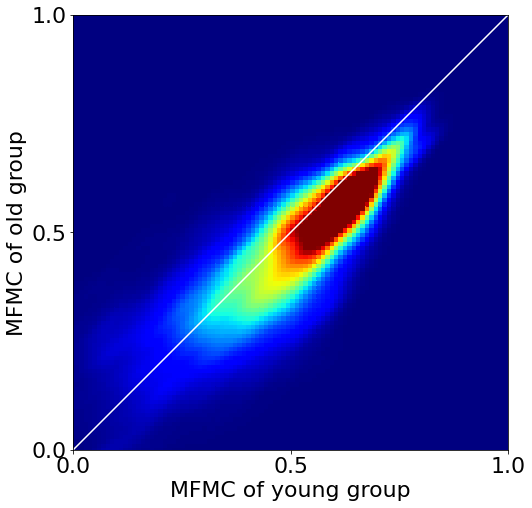

In [22]:
datadir3 = '/home/yang/Documents'

fn_mc_grp1 = '{}/metacorr_dmMdmF_yng_n225.csv'.format(datadir3)
fn_mc_grp2 = '{}/metacorr_dmMdmF_old_n218.csv'.format(datadir3)
metacorr_scatter_heat_plot(fn_mc_grp1, fn_mc_grp2, 'MFMC', [ 0.0, 1.0])

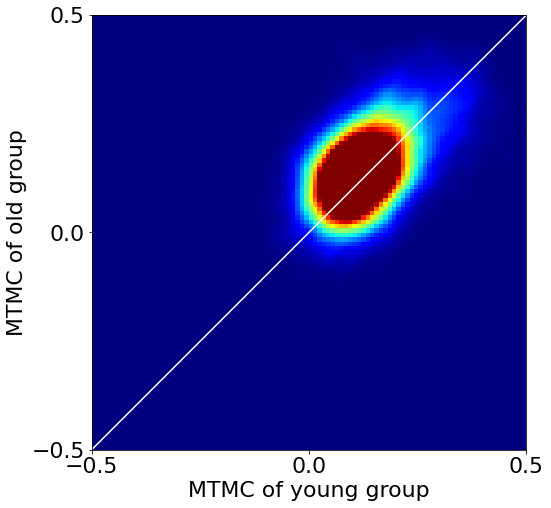

In [23]:
fn_mc_grp1 = '{}/metacorr_dmMdmT_yng_n225.csv'.format(datadir3)
fn_mc_grp2 = '{}/metacorr_dmMdmT_old_n218.csv'.format(datadir3)
metacorr_scatter_heat_plot(fn_mc_grp1, fn_mc_grp2, 'MTMC', [-0.5, 0.5])

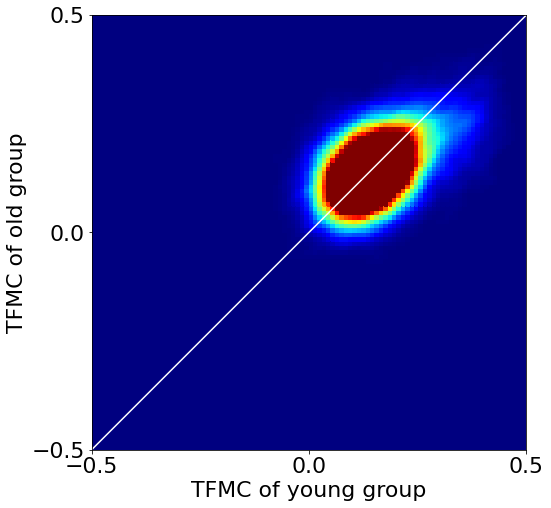

In [24]:
fn_mc_grp1 = '{}/metacorr_dmTdmF_yng_n225.csv'.format(datadir3)
fn_mc_grp2 = '{}/metacorr_dmTdmF_old_n218.csv'.format(datadir3)
metacorr_scatter_heat_plot(fn_mc_grp1, fn_mc_grp2, 'TFMC', [-0.5, 0.5])

In [25]:
print('Reproducibility - age split (voxel level)')
r = reproducibility_metacorr(mfmc_grp1, mfmc_grp2)
print('{}: r = {:.2f}'.format('MFMC',r))
r = reproducibility_metacorr(mtmc_grp1, mtmc_grp2)
print('{}: r = {:.2f}'.format('MTMC',r))
r = reproducibility_metacorr(tfmc_grp1, tfmc_grp2)
print('{}: r = {:.2f}'.format('TFMC',r))

Reproducibility - age split (voxel level)
MFMC: r = 0.83
MTMC: r = 0.48
TFMC: r = 0.45
